In [2]:
from google.colab import drive
drive.mount('/content/gdrive')
import sys
sys.path.append('/content/gdrive/My Drive/Colab Notebooks')
import utils

Mounted at /content/gdrive


In [5]:
%cat /content/gdrive/MyDrive/Colab\ Notebooks/utils.py

import  torch
from    matplotlib import pyplot as plt


def plot_curve(data):
    fig = plt.figure()
    plt.plot(range(len(data)), data, color='blue')
    plt.legend(['value'], loc='upper right')
    plt.xlabel('step')
    plt.ylabel('value')
    plt.show()



def plot_image(img, label, name):

    fig = plt.figure()
    for i in range(6):
        plt.subplot(2, 3, i + 1)
        plt.tight_layout()
        plt.imshow(img[i][0]*0.3081+0.1307, cmap='gray', interpolation='none')
        plt.title("{}: {}".format(name, label[i].item()))
        plt.xticks([])
        plt.yticks([])
    plt.show()


def one_hot(label, depth=10):
    out = torch.zeros(label.size(0), depth)
    idx = torch.LongTensor(label).view(-1, 1)
    out.scatter_(dim=1, index=idx, value=1)
    return out

In [6]:
import torch
from torch import nn
from torch.nn import functional as F
from torch import optim

import torchvision
from matplotlib import pyplot as plt
from utils import plot_image, plot_curve, one_hot

In [7]:
batch_size = 512

# step1. load dataset
train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('mnist_data', train=True, download=True,
                               transform=torchvision.transforms.Compose([
                                   torchvision.transforms.ToTensor(),
                                   torchvision.transforms.Normalize(
                                       (0.1307,), (0.3081,))
                               ])),
    batch_size=batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('mnist_data/', train=False, download=True,
                               transform=torchvision.transforms.Compose([
                                   torchvision.transforms.ToTensor(),
                                   torchvision.transforms.Normalize(
                                       (0.1307,), (0.3081,))
                               ])),
    batch_size=batch_size, shuffle=False)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to mnist_data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to mnist_data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to mnist_data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnist_data/MNIST/raw



torch.Size([512, 1, 28, 28]) torch.Size([512]) tensor(-0.4242) tensor(2.8215)


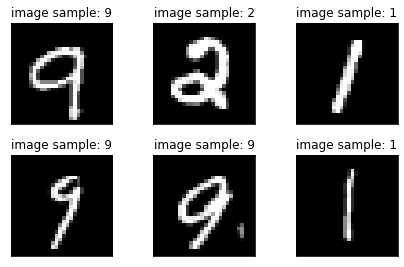

In [8]:
x, y = next(iter(train_loader))
print(x.shape, y.shape, x.min(), x.max())
plot_image(x, y, 'image sample')

In [9]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()

        # xw+b
        self.fc1 = nn.Linear(28*28, 256)
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        # x: [b, 1, 28, 28]
        # h1 = relu(xw1+b1)
        x = F.relu(self.fc1(x))
        # h2 = relu(h1w2+b2)
        x = F.relu(self.fc2(x))
        # h3 = h2w3+b3
        x = self.fc3(x)

        return x

In [10]:
net = Net()
# [w1, b1, w2, b2, w3, b3]
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
train_loss = []

In [11]:
for epoch in range(3):

    for batch_idx, (x, y) in enumerate(train_loader):

        # x: [b, 1, 28, 28], y: [512]
        # [b, 1, 28, 28] => [b, 784]
        x = x.view(x.size(0), 28*28)
        # => [b, 10]
        out = net(x)
        # [b, 10]
        y_onehot = one_hot(y)
        # loss = mse(out, y_onehot)
        loss = F.mse_loss(out, y_onehot)

        optimizer.zero_grad()
        loss.backward()
        # w' = w - lr*grad
        optimizer.step()

        train_loss.append(loss.item())

        if batch_idx % 10==0:
            print(epoch, batch_idx, loss.item())

0 0 0.13306684792041779
0 10 0.10499551147222519
0 20 0.08722396194934845
0 30 0.08054438978433609
0 40 0.07620091736316681
0 50 0.07140462845563889
0 60 0.06730122119188309
0 70 0.06420131027698517
0 80 0.06071159243583679
0 90 0.0582544207572937
0 100 0.056084971874952316
0 110 0.05093427747488022
1 0 0.05003020167350769
1 10 0.04883700981736183
1 20 0.04802015796303749
1 30 0.04746747016906738
1 40 0.045532308518886566
1 50 0.04420163482427597
1 60 0.04194696992635727
1 70 0.039729245007038116
1 80 0.03978460282087326
1 90 0.04051293060183525
1 100 0.037857845425605774
1 110 0.03981119021773338
2 0 0.0384875163435936
2 10 0.03633948415517807
2 20 0.03768813982605934
2 30 0.03536934033036232
2 40 0.03431151807308197
2 50 0.03589024767279625
2 60 0.03234505653381348
2 70 0.034875646233558655
2 80 0.03483114391565323
2 90 0.03572913631796837
2 100 0.033984340727329254
2 110 0.03550831601023674


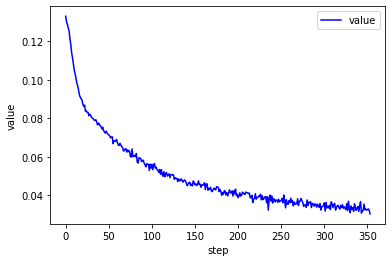

In [12]:
plot_curve(train_loss)

In [13]:
total_correct = 0
for x,y in test_loader:
    x  = x.view(x.size(0), 28*28)
    out = net(x)
    # out: [b, 10] => pred: [b]
    pred = out.argmax(dim=1)
    correct = pred.eq(y).sum().float().item()
    total_correct += correct

In [14]:
total_num = len(test_loader.dataset)
acc = total_correct / total_num
print('test acc:', acc)

test acc: 0.8857


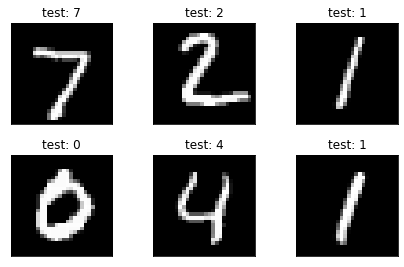

In [15]:
x, y = next(iter(test_loader))
out = net(x.view(x.size(0), 28*28))
pred = out.argmax(dim=1)
plot_image(x, pred, 'test')

In [21]:
%cd /content/gdrive/MyDrive/Github/Deep_Learning_notebook/

/content/gdrive/MyDrive/Github/Deep_Learning_notebook


In [22]:
!git status

On branch main
Your branch is up to date with 'origin/main'.

Untracked files:
  (use "git add <file>..." to include in what will be committed)

	Mnist.ipynb
	mnist_data/

nothing added to commit but untracked files present (use "git add" to track)


In [23]:
!git add Mnist.ipynb

In [25]:
!git commit -m 'Handwrite test for Pytorch'


*** Please tell me who you are.

Run

  git config --global user.email "you@example.com"
  git config --global user.name "Your Name"

to set your account's default identity.
Omit --global to set the identity only in this repository.

fatal: unable to auto-detect email address (got 'root@af869f50954b.(none)')


In [28]:
!git config --global user.email "mrxuanmo@gmail.com"
!git config --global user.name "Daoming Wan"

In [ ]:
!git push